In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fft import dctn, idctn
import heapq
from collections import defaultdict, Counter
import os
import pandas as pd
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [17]:

Q_LUM = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

def get_scaled_q_table(quality_factor):
    """Scales the quantization table based on the quality factor."""
    if quality_factor >= 50:
        scale = (100 - quality_factor) / 50.0
    else:
        scale = 50.0 / quality_factor
    
    if scale == 0: # Quality factor is 100
        scaled_q = np.ones((8, 8))
    else:
        scaled_q = np.floor(Q_LUM * scale)
   
    scaled_q[scaled_q == 0] = 1
    scaled_q[scaled_q > 255] = 255
    return scaled_q.astype(np.uint8)

In [18]:
class HuffmanNode:
    def __init__(self, char, freq):
        self.char = char
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(data):
    frequency = Counter(data)
    priority_queue = [HuffmanNode(char, freq) for char, freq in frequency.items()]
    heapq.heapify(priority_queue)

    while len(priority_queue) > 1:
        left = heapq.heappop(priority_queue)
        right = heapq.heappop(priority_queue)
        merged = HuffmanNode(None, left.freq + right.freq)
        merged.left = left
        merged.right = right
        heapq.heappush(priority_queue, merged)
    return priority_queue[0]

def generate_huffman_codes(root, current_code="", codes={}):
    if root is None:
        return {}
    if root.char is not None:
        codes[root.char] = current_code
        return codes
    
    generate_huffman_codes(root.left, current_code + "0", codes)
    generate_huffman_codes(root.right, current_code + "1", codes)
    return codes

def huffman_encode(data, codes):
    return "".join(codes[char] for char in data)

def huffman_decode(encoded_data, root):
    decoded_output = []
    current_node = root
    for bit in encoded_data:
        if bit == '0':
            current_node = current_node.left
        else:
            current_node = current_node.right
        
        if current_node.char is not None:
            decoded_output.append(current_node.char)
            current_node = root
    return decoded_output

In [19]:

ZIGZAG_ORDER = np.array([
    0, 1, 8, 16, 9, 2, 3, 10, 
    17, 24, 32, 25, 18, 11, 4, 5, 
    12, 19, 26, 33, 40, 48, 41, 34, 
    27, 20, 13, 6, 7, 14, 21, 28, 
    35, 42, 49, 56, 57, 50, 43, 36, 
    29, 22, 15, 23, 30, 37, 44, 51, 
    58, 59, 52, 45, 38, 31, 39, 46, 
    53, 60, 61, 54, 47, 55, 62, 63
])

def compress_channel(channel, quality_factor):
  
    q_table = get_scaled_q_table(quality_factor)
    
    
    h, w = channel.shape
    quantized_coeffs_list = []
    
    for y in range(0, h, 8):
        for x in range(0, w, 8):
            block = channel[y:y+8, x:x+8].astype(np.float32) - 128
            
          
            dct_block = dctn(block, type=2, norm='ortho')
            
           
            quantized_block = np.round(dct_block / q_table).astype(np.int16)
            
         
            quantized_coeffs_list.extend(quantized_block.flatten()[ZIGZAG_ORDER])
            
    # 4. Huffman Encoding
    huffman_tree = build_huffman_tree(quantized_coeffs_list)
    huffman_codes = generate_huffman_codes(huffman_tree, "", {})
    encoded_data = huffman_encode(quantized_coeffs_list, huffman_codes)
    
    return encoded_data, huffman_tree

def decompress_channel(encoded_data, huffman_tree, shape, quality_factor):
    h, w = shape
    q_table = get_scaled_q_table(quality_factor)
    
    # 1. Huffman Decoding
    decoded_coeffs = huffman_decode(encoded_data, huffman_tree)
    
    # Reconstruct blocks
    reconstructed_channel = np.zeros(shape)
    coeff_index = 0
    
    for y in range(0, h, 8):
        for x in range(0, w, 8):
            
            zigzag_block = np.array(decoded_coeffs[coeff_index:coeff_index+64])
            inverse_zigzag_block = zigzag_block[np.argsort(ZIGZAG_ORDER)].reshape(8, 8)
            coeff_index += 64
            
           
            dequantized_block = inverse_zigzag_block * q_table
            
            
            idct_block = idctn(dequantized_block, type=2, norm='ortho')
            
            reconstructed_channel[y:y+8, x:x+8] = idct_block + 128
    
    return np.clip(reconstructed_channel, 0, 255).astype(np.uint8)

Processing for Quality Factor: 90...
Processing for Quality Factor: 70...
Processing for Quality Factor: 50...
Processing for Quality Factor: 30...
Processing for Quality Factor: 10...

--- Compression Analysis Table ---
 Quality Factor Compression Ratio   BPP PSNR (dB)   SSIM
             90            0.28:1 4.807     44.90 0.9952
             70            0.32:1 4.206     43.76 0.9941
             50            0.34:1 3.935     34.35 0.9573
             30            0.38:1 3.553     30.83 0.8793
             10            0.42:1 3.217     27.11 0.7279


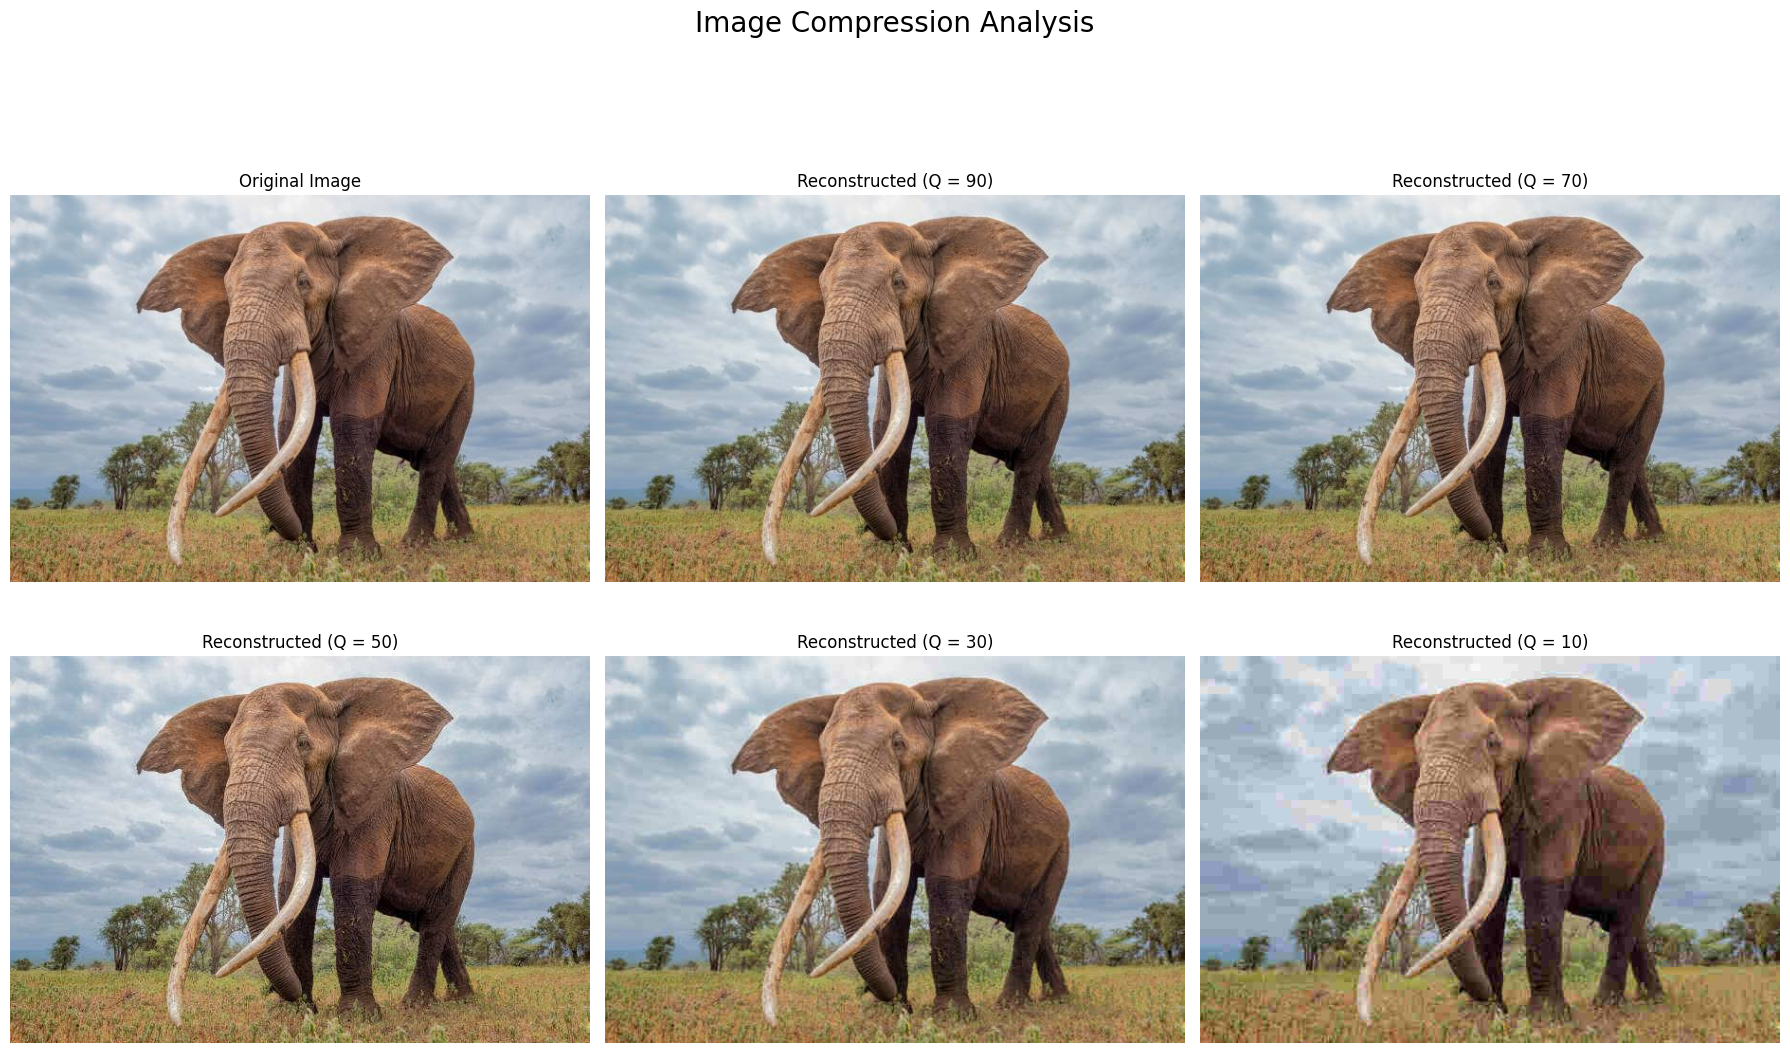

In [20]:

image_path = 'D:\FDIP MODEL TRAINING\FDIP research paper\elephant.jpg' 
original_image_bgr = cv2.imread(image_path)
if original_image_bgr is None:
    raise FileNotFoundError("Image not found. Please check the path.")

original_image_ycrcb = cv2.cvtColor(original_image_bgr, cv2.COLOR_BGR2YCrCb)
original_image_rgb = cv2.cvtColor(original_image_bgr, cv2.COLOR_BGR2RGB)


y, cr, cb = cv2.split(original_image_ycrcb)
h, w = y.shape


pad_h = (8 - h % 8) % 8
pad_w = (8 - w % 8) % 8


y_padded = cv2.copyMakeBorder(y, 0, pad_h, 0, pad_w, cv2.BORDER_REPLICATE)
cr_padded = cv2.copyMakeBorder(cr, 0, pad_h, 0, pad_w, cv2.BORDER_REPLICATE)
cb_padded = cv2.copyMakeBorder(cb, 0, pad_h, 0, pad_w, cv2.BORDER_REPLICATE)


quality_factors = [90, 70, 50, 30, 10]
results = []
reconstructed_images = {}


for qf in quality_factors:
    print(f"Processing for Quality Factor: {qf}...")
    
    encoded_y, tree_y = compress_channel(y_padded, qf)
    encoded_cr, tree_cr = compress_channel(cr_padded, qf)
    encoded_cb, tree_cb = compress_channel(cb_padded, qf)
    
    
    recon_y = decompress_channel(encoded_y, tree_y, y_padded.shape, qf)
    recon_cr = decompress_channel(encoded_cr, tree_cr, cr_padded.shape, qf)
    recon_cb = decompress_channel(encoded_cb, tree_cb, cb_padded.shape, qf)

    
    reconstructed_padded_ycrcb = cv2.merge([recon_y, recon_cr, recon_cb])
    
    
    reconstructed_ycrcb = reconstructed_padded_ycrcb[0:h, 0:w]
    
    
    reconstructed_rgb = cv2.cvtColor(reconstructed_ycrcb, cv2.COLOR_YCrCb2RGB)
    reconstructed_images[qf] = reconstructed_rgb
    
    
    original_size_bits = os.path.getsize(image_path) * 8
    compressed_size_bits = len(encoded_y) + len(encoded_cr) + len(encoded_cb)
    num_pixels = original_image_rgb.shape[0] * original_image_rgb.shape[1]
    
    compression_ratio = original_size_bits / compressed_size_bits
    bpp = compressed_size_bits / num_pixels
    current_psnr = psnr(original_image_rgb, reconstructed_rgb)
    current_ssim = ssim(original_image_rgb, reconstructed_rgb, channel_axis=2, data_range=255)
    
    results.append({
        "Quality Factor": qf,
        "Compression Ratio": f"{compression_ratio:.2f}:1",
        "BPP": f"{bpp:.3f}",
        "PSNR (dB)": f"{current_psnr:.2f}",
        "SSIM": f"{current_ssim:.4f}"
    })


results_df = pd.DataFrame(results)
print("\n--- Compression Analysis Table ---")
print(results_df.to_string(index=False))


fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Image Compression Analysis', fontsize=20)

axes[0, 0].imshow(original_image_rgb)
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

for i, qf in enumerate(quality_factors, 1):
    ax = axes[i // 3, i % 3]
    ax.imshow(reconstructed_images[qf])
    ax.set_title(f'Reconstructed (Q = {qf})')
    ax.axis('off')


if len(quality_factors) + 1 < 6:
    axes[1, 2].axis('off')
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()